# Train multiple models on tiles
Use the fastai package to:
1. Check if their lr schedule, models, etc. perform resonably compared to pytorch implementation in "tile_classifier"
2. Get idea of which models performs best 
3. See if ensembling models is useful, given that they are all trained on the same data
  1. Try training the same model multiple times with same data and ensembling
  2. Training different models and ensembling
  
  
** All of this is using the fastai conda env **

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import os
import sys
# Base Directory where data is stored
# PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'
PATH = '/media/rene/Data/camelyon_out/tiles_299_1t'

MODEL_PATH = 'media/rene/Data/camelyon_out/trained_models'

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

In [2]:
# put the models trained on a dataset in it
if not os.path.exists(os.path.join(PATH,'models')):
    os.makedirs(os.path.join(PATH,'models'))
if not os.path.exists(os.path.join(PATH,'sample')):
    os.makedirs(os.path.join(PATH,'sample'))

# Set it to use GPU0
torch.cuda.set_device(0)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


## Test a couple learning rate schedules
* Get an idea what works, can use as a starting point for all models

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      1.075054   615.208191 0.864005  



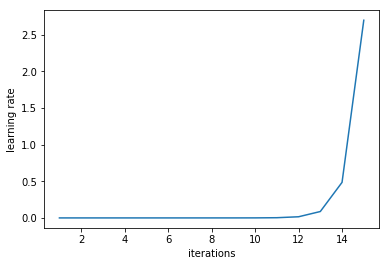

In [3]:
sz=224 # downsample to the same size for resnet
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=False)
lrf=learn.lr_find(start_lr=1e-10, end_lr=15,)
learn.sched.plot_lr()

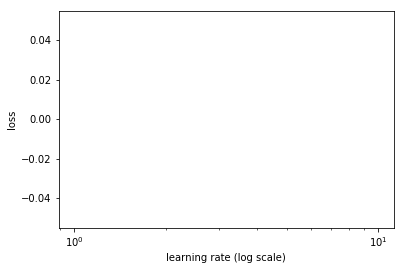

In [4]:
learn.sched.plot()

## Try a couple learning rates to see what works best
####  Resnet50 is probably most standard model, so test this
* Use resonable augmentation, try learning rate schedules
* Test out:
  1. Adam
  2. SGD with restarts
  3. SGD with restarts (differential rates)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.391522   0.361686   0.866898  
    1      0.360869   0.25433    0.882523                  
    2      0.322636   0.235372   0.905671                  
    3      0.285098   0.261221   0.880594                  
    4      0.269915   0.223228   0.906636                  
    5      0.247489   0.235118   0.902392                  
    6      0.24169    0.236648   0.883873                  
    7      0.236949   0.249003   0.906636                  
    8      0.23801    0.240365   0.902392                  
    9      0.234617   0.233876   0.886767                  



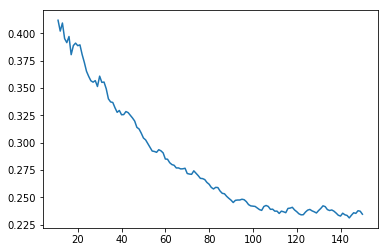

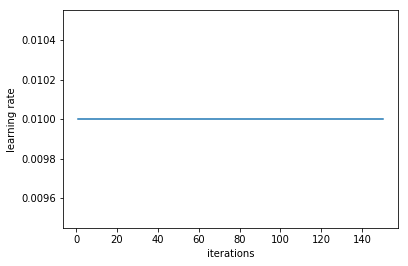

In [14]:
lr=np.array([0, 0, 1e-2])
arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1.2)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr,  10)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.428291   0.364531   0.85841   
    1      0.338289   0.270656   0.877315                  
    2      0.292747   0.25176    0.885802                  
    3      0.275251   0.240505   0.896219                  
    4      0.258337   0.251525   0.891011                  
    5      0.250199   0.246708   0.903356                  
    6      0.243181   0.245605   0.891011                  
    7      0.238783   0.257149   0.896219                  
    8      0.235796   0.254384   0.9076                    
    9      0.241906   0.258749   0.886767                  



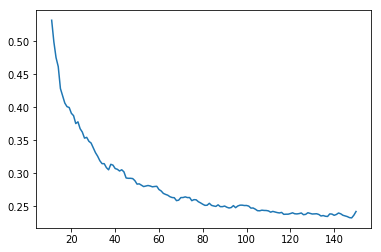

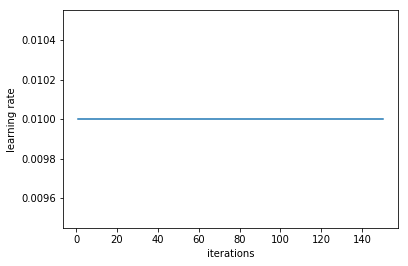

In [15]:
lr = 1e-2
arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1.2)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr,  10)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.477191   0.426447   0.834684  
    1      0.408415   0.334728   0.865934                  
    2      0.356127   0.322758   0.881559                  
    3      0.327712   0.312839   0.889082                  
    4      0.298398   0.296792   0.906636                  
    5      0.275332   0.295455   0.911844                  
    6      0.272501   0.291814   0.911844                  



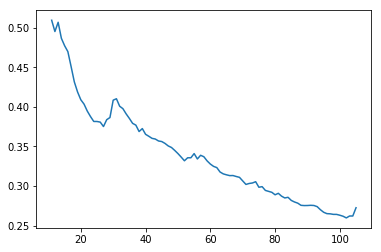

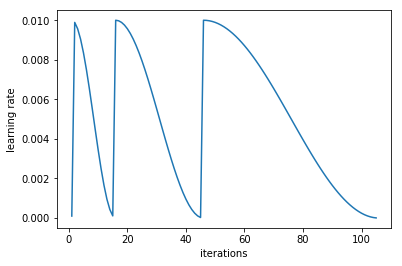

In [25]:
lr = 1e-2
arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1.2)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.462851   0.458717   0.832369  
    1      0.373371   0.289264   0.887731                  
    2      0.330135   0.292085   0.880594                  
    3      0.313531   0.288457   0.898148                  
    4      0.290985   0.292215   0.897184                  
    5      0.277008   0.287142   0.908565                  
    6      0.268164   0.280077   0.903356                  



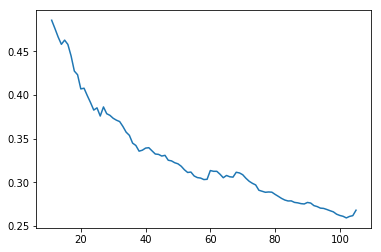

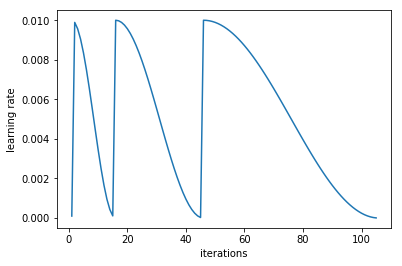

In [24]:
lr=np.array([1e-4,1e-3,1e-2])

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1.2)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.458065   0.443597   0.853202  
    1      0.365004   0.307066   0.9076                    
    2      0.31245    0.300636   0.902392                  
    3      0.28995    0.308978   0.891975                  
    4      0.275957   0.295569   0.902392                  
    5      0.263282   0.28586    0.9076                    
    6      0.25826    0.282103   0.9076                    



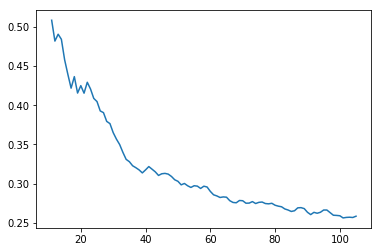

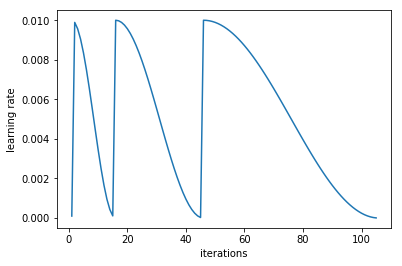

In [23]:
# Maybe we don't want zooming?
lr=np.array([1e-4,1e-3,1e-2])

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.527739   0.590998   0.821952  
    1      0.403714   0.305474   0.897184                  
    2      0.361575   0.31779    0.886767                  
    3      0.312174   0.307188   0.896219                  
    4      0.293638   0.304442   0.9076                    
    5      0.273597   0.292021   0.918017                  
    6      0.253758   0.296925   0.912809                  



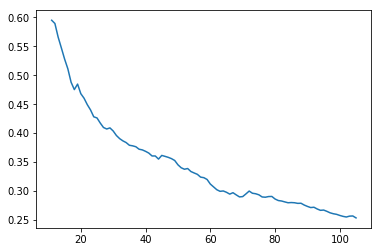

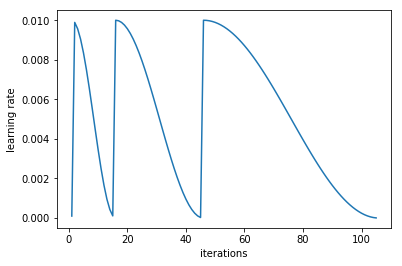

In [28]:
# Maybe we don't want zooming?
lr=np.array([1e-3,5e-3,1e-2])

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.459447   0.471218   0.863619  
    1      0.358      0.278175   0.891975                  
    2      0.325791   0.296542   0.902392                  
    3      0.293966   0.317708   0.881559                  
    4      0.275233   0.296479   0.902392                  
    5      0.262685   0.287377   0.912809                  
    6      0.250059   0.295478   0.912809                  



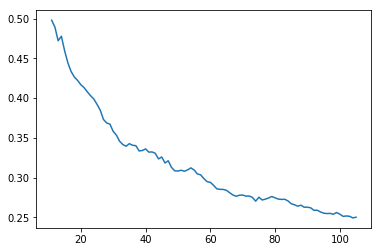

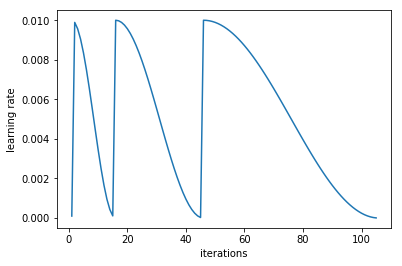

In [29]:
# check that it wasn't using the rescaled 299 data that is the issue. No
PATH = '/media/rene/Data/camelyon_out/tiles_224_1t'

lr=np.array([1e-3,5e-3,1e-2])

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()# Maybe we don't want zooming?
lr=np.array([1e-3,5e-3,1e-2])

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.445713   0.430391   0.832369  
    1      0.350376   0.302709   0.897184                  
    2      0.303988   0.29924    0.896219                  
    3      0.281044   0.297215   0.897184                  
    4      0.265337   0.295783   0.897184                  
    5      0.256176   0.308969   0.897184                  
    6      0.248478   0.318055   0.897184                  



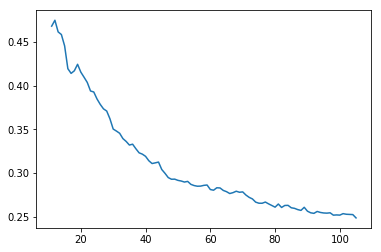

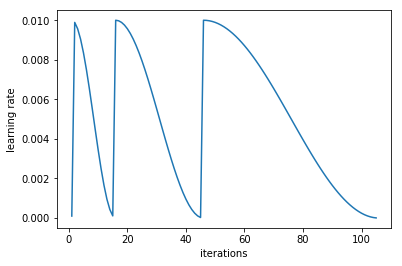

In [30]:
#what if we don't rescale? bad
lr=np.array([1e-3,5e-3,1e-2])

arch=resnet50
tfms = tfms_from_model(resnet50, 299, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

Result:
* Use 224 size
* SGDR is slighyly better, and best bet: cycle_len=1, cycle_mult=2

## Test models individually to get an idea of performance
models:
* resnet34
* resnet50
* resnet101
* vgg16
* resnext50
* resnext101
* inceptionresnet_2
* inception_4
* dn121
* dn169

** Does it matter if we read in the 224x224, or scall the 299x299? ** 

In [ ]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

lr=np.array([1e-3,5e-3,1e-2])

for idx, arch in enumerate(models):
    if arch in [inceptionresnet_2, inception_4]:
        sz = 299
        PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'
    else:
        sz = 224
        PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'

    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms)
    
    print(models_name[idx])
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name[idx])

resnet34


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/1302 [00:00<?, ?it/s]                  


Exception in thread Thread-420:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.255341   0.231327   0.895518  
    1      0.253622   0.231133   0.893491                      
    2      0.242353   0.224276   0.898388                      
    3      0.248091   0.227568   0.89899                       
    4      0.258412   0.215891   0.903716                      
    5      0.235607   0.214045   0.902698                      
    6      0.227546   0.212328   0.903776                      

resnet50


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.236542   0.208497   0.905152  
    1      0.229533   0.193573   0.910189                      
    2      0.21807    0.19953    0.908928                      
    3      0.222059   0.203794   0.906294                      
    4      0.208814   0.193822   0.913586                      
    5      0.207671   0.193967   0.912153                      
    6      0.209226   0.188228   0.916994                      

resnet101


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.237373   0.207407   0.902522  
    1      0.227158   0.190388   0.914376                      
    2      0.215104   0.187965   0.915274                      
    3      0.219308   0.190654   0.913418                      
    4      0.211119   0.179419   0.918866                      
    5      0.213924   0.179406   0.92138                       
    6      0.201884   0.180645   0.92132                       

vgg16


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.266662   0.232219   0.893718  
    1      0.249728   0.224433   0.898867                      
    2      0.254703   0.215796   0.902279                      
    3      0.244774   0.216093   0.90198                       
    4      0.254539   0.222483   0.895993                      
    5      0.237156   0.208507   0.905803                      
    6      0.230583   0.208373   0.904785                      

resnext50


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.223736   0.207713   0.905456  
    1      0.220997   0.195159   0.914017                      
    2      0.223653   0.191198   0.91677                       
    3      0.224033   0.188591   0.915633                      
    4      0.212011   0.184905   0.918143                      
    5      0.203431   0.185212   0.916531                      
    6      0.210347   0.18279    0.9197                        

resnext101


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.23134    0.194227   0.913119  
    1      0.226533   0.189073   0.913957                      
    2      0.206577   0.18417    0.917609                      
    3      0.211413   0.190894   0.91246                       
    4      0.207527   0.180603   0.922039                      
    5      0.213245   0.182499   0.918746                      
    6      0.197984   0.178461   0.920243                      

inceptionresnet_2


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.247449   0.228005   0.897071  
    1      0.247835   0.221427   0.903177                      
    2      0.241098   0.211291   0.905811                      
    3      0.230133   0.212111   0.908086                      
  6%|▌         | 81/1302 [00:40<10:04,  2.02it/s, loss=0.239]

## Test all models:

In [58]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

lr=np.array([1e-3,5e-3,1e-2])

for idx, arch in enumerate(models):
    if arch in [inceptionresnet_2, inception_4]:
        sz = 299
    else:
        sz = 224

    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms)
    
    model_loc = os.path.join(PATH, 'models', models_name[idx])
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.load(model_loc)
    preds, y = learn.predict_with_targs(is_test=False)
    print(models_name[idx], ':   ', accuracy_np(preds, y))

KeyboardInterrupt: 

In [48]:
??accuracy_np()